In [2]:
import os

import matplotlib.pyplot as plt

from astropy.table import Table
from astropy.io import ascii

from astropy import units as u
from astropy.coordinates import SkyCoord

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)

from scipy import ndimage

import numpy as np

In [3]:
cat = Table.read("./data/s82grn4.fit")

ra_gal = cat['RAJ2000'].value
dec_gal = cat['DEJ2000'].value
zz_gal = cat['z'].value

dist_gal = cosmo.comoving_distance(zz_gal).value # Mpc

coords_gal = SkyCoord(ra = ra_gal * u.degree, dec = dec_gal * u.degree, distance = dist_gal * u.Mpc)

x_gal = coords_gal.cartesian.x
y_gal = coords_gal.cartesian.y
z_gal = coords_gal.cartesian.z

In [4]:
from utils.decomposition import bulge, disk

In [5]:
#arcsec
radii = np.arange(0.01, 20, 0.01) 

# calculate surface-brightness at r = 0
mu0_n4 = []

for idx in range(len(cat)):
    # bulge to total ratio
    btt = cat['B_Tr'][idx]

    #flux per area
    flux_bulge_arb = bulge(r = radii, Sig_e = 10, r_e = cat['hlrr'][idx], n = cat['n'][idx])
    flux_disk_arb = disk(r = radii, Sig_0 = 10, r_d = cat['hlrr'][idx])
    flux_disk_arb *= sum(flux_bulge_arb)/sum(flux_disk_arb) * (1 - btt) / btt

    petro_r50 = cat['R50g'][idx]
    petro_r50_idx = int(petro_r50 // 0.01)

    #flux within r50 to SB
    flux_bulge_arb_r50 = flux_bulge_arb[:petro_r50_idx]
    flux_disk_arb_r50 = flux_disk_arb[:petro_r50_idx]
    flux_total_arb_r50 = flux_bulge_arb_r50 + flux_disk_arb_r50

    flux_avg_r50 = [flux_total_arb_r50[ii] * 2 * np.pi * 0.01**2 * (ii+1) for ii in range(len(flux_total_arb_r50))] 
    flux_avg_r50 = np.sum(flux_avg_r50) / (np.pi * petro_r50**2)

    # SB in R50 catalog / smae derived
    factor = 10**((cat['mu50g'][idx] - 30) / -2.5) / flux_avg_r50
    flux_bulge_corr = flux_bulge_arb * factor * btt
    flux_disk_corr = flux_disk_arb * factor * (1 - btt)
    flux_total = flux_bulge_corr + flux_disk_corr
    # flux_corr = 10**((sb_arb - 30) / -2.5) * factor
    sb_bulge_corr = -2.5 * np.log10(flux_bulge_corr) + 30
    sb_disk_corr = -2.5 * np.log10(flux_disk_corr) + 30
    sb_total = -2.5 * np.log10(flux_total) + 30
    
    mu0 = sb_disk_corr[0]
    mu0_n4.append(mu0)

mu0_n4 = np.array(mu0_n4)

/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log10
/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply
/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log10


In [18]:
z_mask = (cat['z'] > 0.015) & (cat['z'] < 0.055)
sf_mask = mu0_n4 > 23
inc_mask = (cat['inc'] <= 75) & (cat['inc'] >= 0)
# sersic_mask = (tbl_n4[])

lsb_mask = sf_mask & inc_mask & z_mask
hsb_mask = ~sf_mask & inc_mask & z_mask

sum(lsb_mask), sum(hsb_mask)

(460, 2339)

In [7]:
from utils.mistree import construct_mst, get_graph_degree, get_branch_index, get_branch_end_index

In [8]:
grps = Table.read("./data/group_DR7/modelA_group", format = 'ascii')

grps['col1'].name = 'id'
grps['col2'].name = 'RA'
grps['col3'].name = 'dec'
grps['col4'].name = 'z'
grps['col5'].name = 'L'
grps['col6'].name = 'sm'
grps['col7'].name = 'hm1'
grps['col8'].name = 'hm2'
grps['col9'].name = 'mean_sep1'
grps['col10'].name = 'mean_sep2'
grps['col11'].name = 'f_edge'
grps['col12'].name = 'ID1'
grps['col13'].name = 'ID2'

mask_m = (grps['hm1'] > np.log10(2e12))
mask_z = (grps['z'] > 0.015) & (grps['z'] < 0.055)
mask_coord = ((grps['RA'] < 70) | (grps['RA'] > 290)) & ((grps['dec'] < 5) & (grps['dec'] > -5))
mask_grp = mask_m & mask_z & mask_coord

grps = grps[mask_grp]


In [9]:
ra_grp = grps['RA']
dec_grp = grps['dec']
zz_grp = grps['z']
dist_grp = cosmo.comoving_distance(zz_grp).value # Mpc

coords = SkyCoord(ra = ra_grp * u.degree, dec = dec_grp * u.degree, distance = dist_grp * u.Mpc)

x_grp = coords.cartesian.x
y_grp = coords.cartesian.y
z_grp = coords.cartesian.z

In [10]:
Hs = cosmo.H(grps['z']).value
h =  cosmo.H(0).value / 100
 
G = 4.2e-3 * 1e-6 # Mpc M_sun-1 (km/s)^2

r200 = (( 10**(grps['hm1']) * G / 100 / Hs**2 )**(1/3)).value #mpc

In [11]:
k_neighbours=20
number_of_nodes = len(x_grp)

edge_length, edge_x, edge_y, edge_z, edge_index = construct_mst(x_grp, y_grp, z_grp, k_neighbours)
degree, edge_degree = get_graph_degree(edge_index, number_of_nodes)
branch_index, rejected_branch_index = get_branch_index(edge_index, edge_degree)

In [12]:
from scipy import spatial

In [13]:
tree = spatial.cKDTree(np.array([x_grp, y_grp, z_grp]).T)

d_node_1 = tree.query(np.array([x_gal, y_gal, z_gal]).T, k = 1)

mask_cluster = (d_node_1[0] < r200[d_node_1[1]])
d_node = tree.query(np.array([x_gal, y_gal, z_gal]).T, k = 2)

In [14]:
mask_link = edge_length < 5.75 / h
grp_index = np.where(mask_link)[0]

mask_cand1 = np.isin(d_node[1][:, 0], grp_index)
mask_cand2 = np.isin(d_node[1][:, 1], grp_index)
mask_cand = mask_cand1 & mask_cand2

P1 = np.array([x_grp[d_node[1][:, 0]], y_grp[d_node[1][:, 0]], z_grp[d_node[1][:, 0]]]).T
P2 = np.array([x_grp[d_node[1][:, 1]], y_grp[d_node[1][:, 1]], z_grp[d_node[1][:, 1]]]).T

Pgal = np.array([x_gal, y_gal, z_gal]).T

d_fil = np.linalg.norm(
    np.cross(P2 - Pgal, P1 - Pgal)
    , axis = 1) / np.linalg.norm(P2 - P1, axis = 1)

mask_filament = mask_cand & ~mask_cluster & (d_fil < 4.12 / 0.7)

In [15]:
sum(lsb_mask & mask_cluster), sum(lsb_mask & mask_filament)

(33, 200)

In [16]:
sum(hsb_mask & mask_cluster), sum(hsb_mask & mask_filament)

(153, 993)

Text(0, 0.5, 'Density')

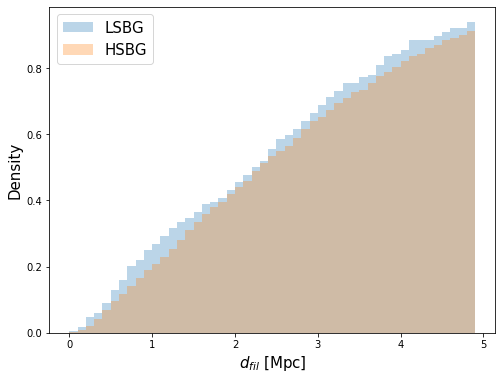

In [20]:
fig, ax = plt.subplots(figsize = (8, 6))

mlsb = lsb_mask & mask_filament
mhsb = hsb_mask & mask_filament
ax.hist(d_fil[mlsb], alpha = .3, weights = np.ones(sum(mlsb))/sum(mlsb), label = 'LSBG', bins = np.arange(0, 5, 0.1), cumulative = True)
ax.hist(d_fil[mhsb], alpha = .3, weights = np.ones(sum(mhsb))/sum(mhsb), label = 'HSBG', bins = np.arange(0, 5, 0.1), cumulative = True)

ax.legend(fontsize = 15)
# ax.hist(d_fil[mhsb], alpha = .3)

ax.set_xlabel('$d_{fil}$ [Mpc]', fontsize = 15)
ax.set_ylabel('Density', fontsize = 15)
# fig.savefig('hist.png')